# An introduction to optimal control using Crocoddyl

## Setup

In [45]:
import gepetuto.magic

## Crocoddyl
For this version of the introduction, we are going to use Crocoddyl V2.0.
Crocoddyl stands for Contact robot control with differential dynamic programming library. We will need it for formulating and solving the optimal control problems. 
There is an alternative version of the same tutorial using ALigator, which might some day be proposed as a future version of Crocoddyl, but is yet released in Beta. If you are already super familiar with Croccodyl and would like to try something new, check out the aternative tutorial. Both versions feature the same pedagogical material, but the syntax is quite different, so choose well choose once, you won't be able to easily change for today's class.

----
# Starting example: the unicycle

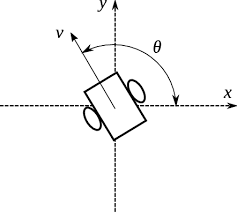

An unicycle represents a kinematic model of a car where it's only possible to move in two directions, i.e. it drives forward and turns on the spot. Its dynamics has nonholonomic constraints because it cannot move sideways. Remember that nonholonomic constraints are nonintegral and has the form $\mathbf{f(q,\dot{q})=0}$.

In this example, we define an optimal-control problem for the classical unicycle problem. Our goal is to drive the unicycle towards the origin but at the same time not too fast. For that, the cost function is described as the sum between the distance to the origin and the system speed.



Basically, our optimal control problem has the following simulation model (ie predicting $x_{next}$ from current state $x$ and control $u$) and cost function:

In [2]:
import numpy as np
x = np.random.rand(3)
u = np.random.rand(2)

# Unicycle dynamical model
v,w = u
c,s = np.cos(x[2]),np.sin(x[2])
dt = 1e-2
dx = np.array([ v*c, v*s, w ])
xnext = x + dx*dt

# Cost function: driving to origin (state) and reducing speed (control)
stateWeight = 1
ctrlWeight = 1
costResiduals = np.concatenate([stateWeight*x,ctrlWeight*u])
cost = .5* sum(costResiduals**2)

## Crocoddyl model of the unicycle


For this basic example, the unicycle model is coded in the library. We will just load it and use it. If you are very curious, have a look! It is in https://github.com/loco-3d/crocoddyl/blob/master/include/crocoddyl/core/actions/unicycle.hxx . We will show you below how a similar model can be developped in Python (easier for prototyping, but far less efficient).

We create such a model with the following lines:

In [7]:
import crocoddyl
model = crocoddyl.ActionModelUnicycle()
data  = model.createData()

The action model contains ... well ... the description of the dynamics and cost function. There you find also the action model parameters (here the time step and the cost weights). On the other hand, the data has the buffers where the results of the calculus are stored.

We decided for this separation for an obvious reason that is given just below.

In [8]:
model.costWeights = np.array([
    1,   # state weight
    1  # control weight
])

## Defining the shooting problem
Now we have the action model, let's define the complete problem.
A shooting problem is defined by the initial state from which computing the rollout and a sequence of action models.


In [9]:
# %load tp5/generated/unicycle_solutions_hyperparams
### HYPER PARAMS: horizon and initial state
T  = 100
x0 = np.array([-1,-1,1])


In [10]:
problem = crocoddyl.ShootingProblem(x0, [ model ] * T, model)

Here we define a problem starting from $\mathbf{x}_0$ with 20 timesteps (of 0.1 sec by default implementation of unicycle). The terminal action model is defined using the running action model.

This defines the model, not any algorithm to solve it. The only computation that the problem can provide is to integrate the system for a given sequence of controls.

In [16]:
us = [ np.array([1., .1]).T for t in range(T)]
xs = problem.rollout(us)

The plotUnicycle function plots the system as two arrows that represent the wheels

(-3.0, 1.0, -2.0, 2.0)

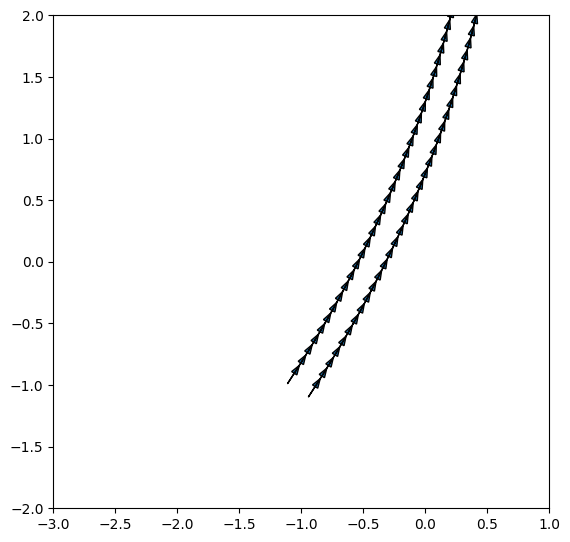

In [17]:
%matplotlib inline
import matplotlib.pylab as plt
from utils.unicycle import plotUnicycleSolution
plotUnicycleSolution(xs)
plt.axis([-3,1.,-2.,2.])

## Solve the OCP
The main solver is named SolverDDP. Other solvers exist, and you can also add other solvers (taken off the shelf, reimplemented from the literature and invented by yourselves). More on this in the second exercise. 

The DDP solver is initialized with the problem object and mostly contains the ddp.solve method. 

In [30]:
# %load tp1/generated/unicycle_toward_origin_ddp
# Select the solver for this problem
ddp = crocoddyl.SolverDDP(problem)


A useful tool, classical to many solvers, is the callback function, that will be called at every iteration. Here we set up two of them: the first will verbosely comment the solver progress, and the second log the progress for later exploitation in plots.

In [32]:
# %load tp1/generated/unicycle_toward_origin_callback
# Add solvers for verbosity and plots
ddp.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])


We can warm start it and tune the parameters, but for the simple unicycle, let's just solve it!

In [35]:
# %load tp1/generated/unicycle_toward_origin_solve
done = ddp.solve()
assert(done)

iter    cost       merit      stop       grad       preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  2.456e+01  0.000e+00  0.000e+00  0.000e+00  1.000e-09  1.000e-09  1.0000  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -2.456e+01  0.000e+00  0.000e+00
   1  1.730e+01  0.000e+00  7.258e+00  1.452e+01  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  7.258e+00  7.265e+00  0.000e+00  0.000e+00
   2  1.724e+01  0.000e+00  5.455e-02  1.091e-01  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  5.455e-02  5.407e-02  0.000e+00  0.000e+00
   3  1.724e+01  0.000e+00  2.502e-03  5.004e-03  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  2.502e-03  2.391e-03  0.000e+00  0.000e+00
   4  1.724e+01  0.000e+00  1.758e-04  3.516e-04  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.758e-04  1.623e-04  0.000e+00  0.000e+00
   5  1.724e+01  0.000e+00  1.462e-05  2.923e-05  1.000e-09  1.000e

Let's plot the result

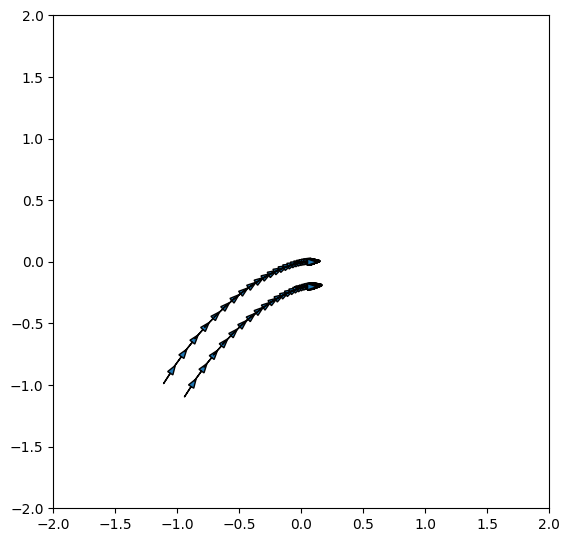

In [36]:
plotUnicycleSolution(ddp.xs)

The solver journey is typically plotted like this.

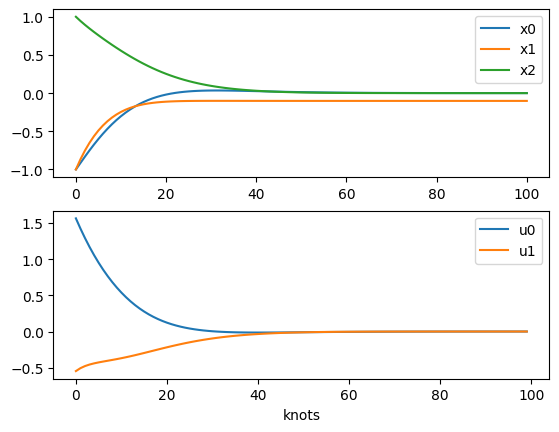

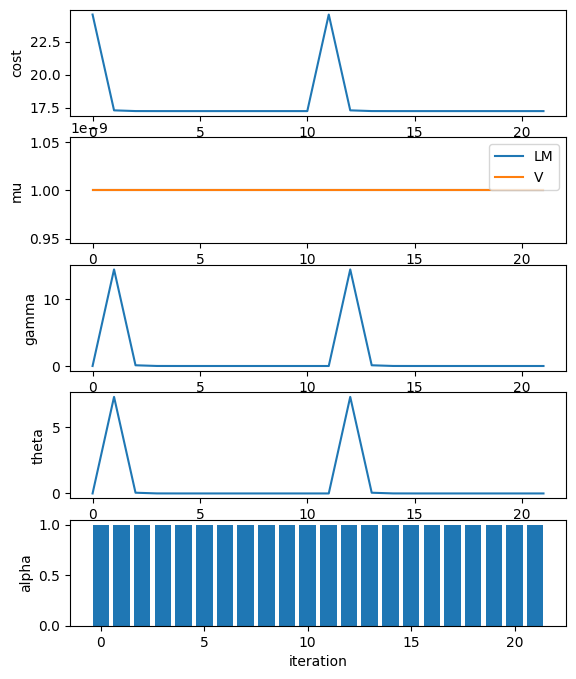

In [38]:
# %load tp1/generated/unicycle_toward_origin_plotlog
log = ddp.getCallbacks()[0]
crocoddyl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
crocoddyl.plotConvergence(
    log.costs,
    log.pregs,
    log.dregs,
    log.grads,
    log.stops,
    log.steps,
    figIndex=2,
    show=False,
)


The terminal state chosen by the solver is:

In [39]:
print(ddp.xs[-1])

[ 2.29114996e-04 -1.01830026e-01  2.06212045e-05]


## Well, the terminal state is not so nicely in the origin.

Question 1: why?

Question 2: How can you change this?

Question 3: by changing the cost parameters, the time horizon and the initial position, can you trigger a maneuver?

In [46]:
%do_not_load_snippet tp1/generated/unicycle_toward_origin_termmodel

----
# Defining your own model, exemplified with a bicopter

Unicycle is a very basic example. Most interesting problems in robotics are written at the acceleration level to easily convey forces and action-reaction phenomena. We will now consider a bicopter model (i.e. a UAV evolving in a vertical plane). It is composed of two rotors producing pure orthogonal forces, hence leading to linear and angular accelerations resulting from the thrust and gravity effects. 

## Bicopter equations of motion
The bicopter is defined by its mass $m$, wingspan $l$ (distance from the copter center to each propeller), inertia $i=l^2m$ and gravity $g$. The state $x=(q,v)$ is the concatenation of position and velocity of the copter, with $q=(x_1,x_2,\theta)$, $x_1$ the horizontal position, $x_2$ the vertical position and $\theta$ the angle) and  $v=(v_1,v_2,\omega)$ the horizontal, vertical and angle velocities.
The control is the thrust (vertical forces) of right then leg propellers $(u=(f_r, f_l)$).

The linear and angular forces due to the propellers are easy to express in the local frame:
$$f = \left(0, f_r+f_l, (f_l-f_r) l \right)$$
The acceleration in world frame is then obtained by rotating the linear forces, dividing by mass and inertia and adding the gravity:
$$a = \left(\frac{f[1] \sin(\theta)}{m}, \frac{f[1] \cos(\theta)}{m}-g, \frac{f[2]}{i} \right)$$



## Integration of the motion equations
Like for the unicyle model, we need to integrate this quantity to get the next state $x_{next}$ from the current state $x$ and control $u$. Now, the bicopter is in acceleration, so the integration should be repeated twice (from acceleration to position). We could do that directly in the action model. Yet Crocoddyl is proposing to split this in two different classes, specifically for acceleration-based models.
- The *differential* action model (DAM) implement the (acceleration) equation of motion and integral cost written as a differential.
- The *integral* action model (IAM) takes the differential and numerically integrates it. We mostly propose to use Euler integration (although RK4 integration is also available, and other integrator can be implemented). The next state $x_+=(q_+,v_+)$ is then obtained from $x=(q,v)$ and the computed acceleration:
$$v_+ = v + a \Delta t$$
$$q_+ = q + v_+ \Delta t$$
with $\Delta t$ the integration step, defined as a hyperparameter (tune it with the trade-off between numerical accuracy --pleading for small $\Delta t$-- and computational efficiency --pleading for large $\Delta t$). Note the $v_+$ in the second row: we call that *implicit* Euler integration, and it is marginally more stable.


In Crocoddyl, we often write the costs as a sum of square. The cost $\ell(x,u)$ is typically defined as:
$$\ell(x,u) = \frac{1}{2} r(x,u)^T r(x,u)$$
with $r(x,u)$ is called the residuals.
This has the practical consequence that we can approximate the Hessian of the cost $H$ can be approximated to the squared of the residual Jacobian, e.g.:
$$\frac{\partial^2 \ell}{\partial x^2} \approx \frac{\partial r}{\partial x}^T \frac{\partial r}{\partial x}$$

For the copter, we propose to put quite a lot of terms in $r$ so that you can *play* with many hyperparameters to tune:
$$r=(x_1,x_2,\sin(\theta),1-\cos(\theta),v,u,a) \in \mathbb{R}^{12}$$

Below is a template for the DAM. Implement the equation of motion in the *calc* function. It must compute the acceleration and store it in +data.xout+ (array of size 3); the residual and store it in +data.residual+ (array of size 12); and the cost as half of the sum of $r$ squared.

In [51]:
# %load tp1/generated/bicopter_toward_origin_dam_header
class DifferentialActionModelBicopter(crocoddyl.DifferentialActionModelAbstract):

    def __init__(self):
        '''
        Init on top of the DAM class. 
        Mostly set up the hyperparameters of this model (mass, length, cost, etc).
        '''
        crocoddyl.DifferentialActionModelAbstract.__init__(
            self, crocoddyl.StateVector(6), nu=2, nr=12
        )
        self.unone = np.zeros(self.nu)

        self.span = .2
        self.mass = 2.
        self.g = 10
        self.inertia = self.mass*self.span**2

        self.costWeights = [
            0.1, # x
            0.1, # z
            .10, # s
            .10, # c
            0.001, # vx
            0.001, # vz
            0.001, # w
            0.0, # fr
            0.0, # fl
            0.001,0.001,0.001, # a
        ]  # sin, 1-cos, x, xdot, thdot, f

    def calc(self, data, x, u=None):
        if u is None:
            u = model.unone
        # Getting the state and control variables
        x1,x2,th,v1,v2,w = x
        fr,fl = u

        # ... Type your code here!


Fill this template by adding your own code. You can also define a +calcDiff+ method, with the same signature of +calc+, to compute the derivatives and store them in the corresponding fields of +data+. This is more advanced, useful for accuracy and efficiency. For today, we are rather going to compute the derivatives by finite differencing.